In [6]:
from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import PIL
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

In [7]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [10]:
imsize = 200  # desired size of the output image

loader = transforms.Compose([transforms.Scale(imsize),transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image


style = image_loader("style.jpg").type(dtype)
content = image_loader("saak.jpg").type(dtype)

assert style.size() == content.size(
),"we need to import style and content images of the same size"

In [11]:
unloader = transforms.ToPILImage()  # reconvert into PIL image


def imshow(tensor):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(3, 355, 200)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)


fig = plt.figure()

plt.subplot(221)
imshow(style.data)
plt.subplot(222)
imshow(content.data)

In [12]:
class ContentLoss(nn.Module):
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion.forward(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

In [13]:
class GramMatrix(nn.Module):
    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

In [14]:
class StyleLoss(nn.Module):
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram.forward(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion.forward(self.G, self.target)
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

In [15]:
cnn = models.vgg19(pretrained=True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

In [22]:
# desired depth layers to compute style/content losses :
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# just in order to have an iterable access to or list of content/syle losses
content_losses = []
style_losses = []

model = nn.Sequential()  # the new Sequential module network
gram = GramMatrix()  # we need a gram module in order to compute style targets

# move these modules to the GPU if possible:
if use_cuda:
    model = model.cuda()
    gram = gram.cuda()

# weigth associated with content and style losses
content_weight = 1
style_weight = 100

i = 1
for layer in list(cnn):
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model.forward(content).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model.forward(style).clone()
            target_feature_gram = gram.forward(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

    if isinstance(layer, nn.ReLU):
        name = "relu_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model.forward(content).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model.forward(style).clone()
            target_feature_gram = gram.forward(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

        i += 1

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(i)
        model.add_module(name, layer)  # ***

In [17]:
input = image_loader("saak.jpg").type(dtype)
# if we want to fill it with a white noise:
input.data = torch.randn(input.data.size()).type(dtype)

In [18]:
# this line to show that input is a parameter that requires a gradient
input = nn.Parameter(input.data)
optimizer = optim.LBFGS([input])

In [19]:
# run = [0]
# while run[0] <= 300:
    
#     def closure():
#         optimizer.zero_grad()
#         model.forward(input)
#         style_score = 0
#         content_score = 0

#         for sl in style_losses:
#             style_score += sl.backward()
#         for cl in content_losses:
#             content_score += cl.backward()

#         run[0]+=1
#         if run[0] % 10 == 0:
#             print("run " + str(run) + ":")
#             print(style_score.data[0])
#             print(content_score.data[0])

#         return content_score+style_score

#     optimizer.step(closure)

In [23]:
run = [0]
while run[0] <= 300:

    def closure():
        # correct the values of updated input image
        input.data.clamp_(0, 1)

        optimizer.zero_grad()
        model.forward(input)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.backward()
        for cl in content_losses:
            content_score += cl.backward()

        run[0]+=1
        if run[0] % 10 == 0:
            print("run " + str(run) + ":")
            print(style_score.data[0])
            print(content_score.data[0])

        return content_score+style_score

    optimizer.step(closure)

# a last correction...
input.data.clamp_(0, 1)

run [10]:
753.993530273
28.661113739
run [20]:
1271.36523438
35.8854942322
run [30]:
429.585510254
23.3118133545
run [40]:
6.58154726028
5.1734418869
run [50]:
0.907709717751
1.91143381596
run [60]:
0.493104934692
1.28428900242
run [70]:
0.358140349388
1.08854651451
run [80]:
0.337747097015
0.998204112053
run [90]:
0.32134655118
0.956395328045
run [100]:
0.309200942516
0.935674309731
run [110]:
0.295765370131
0.939220488071
run [120]:
0.297958910465
1.07874178886
run [130]:
0.302809536457
0.916230142117
run [140]:
0.31856867671
0.901469409466
run [150]:
24.3223285675
7.16106748581
run [160]:
0.624561786652
1.78745424747
run [170]:
0.358584910631
1.12168979645
run [180]:
0.31228736043
0.965371549129
run [190]:
0.305657029152
0.917063891888
run [200]:
0.326346933842
0.990983605385
run [210]:
4.41209363937
4.21233606339
run [220]:
413.920776367
22.3273239136
run [230]:
383.886169434
23.7603130341
run [240]:
12.7577581406
8.79744720459
run [250]:
1.20102834702
2.91698646545
run [260]:
0.40


( 0 , 0 ,.,.) = 
   1   1   1  ...    1   1   0
   1   1   1  ...    1   1   1
   1   1   1  ...    1   1   1
     ...       ⋱       ...    
   0   1   0  ...    1   1   1
   0   1   1  ...    0   1   1
   0   1   1  ...    1   1   1

( 0 , 1 ,.,.) = 
   1   1   1  ...    1   1   1
   1   1   1  ...    1   1   1
   1   1   1  ...    1   1   1
     ...       ⋱       ...    
   1   0   1  ...    0   1   0
   0   0   1  ...    0   1   1
   1   1   1  ...    0   0   1

( 0 , 2 ,.,.) = 
   1   0   1  ...    1   1   1
   1   1   1  ...    1   0   0
   1   1   1  ...    1   1   1
     ...       ⋱       ...    
   0   1   0  ...    0   0   0
   0   0   1  ...    0   0   0
   1   1   0  ...    0   0   0
[torch.FloatTensor of size 1x3x355x200]

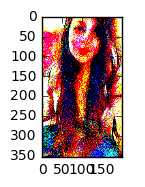

In [24]:
input.data
plt.subplot(224)
imshow(input.data)
plt.show()